<h2>Comparing Selected Subreddits</h2>
<h3>Exercises in Natural Language Processing and Reddit API</h3>

<h3>Introduction</h3><br>
As I have been teaching myself the basics of Natural Language Processing (<a href='https://en.wikipedia.org/wiki/Natural_language_processing'>NLP</a>), I have wanted to construct an relatively rich example of NLP using data with which I was somewhat familiar.  A natural choice for me was analysis of data from <a href='https://www.reddit.com/'>Reddit</a>, my social media of choice.
In this notebook I demonstrate such an analysis.  Using Python, I compared comments from 19 subreddits on the basis of the following lexical characteristics:

* Text complexity (readability)
* Relationship between text complexity and comment scoring
* Word frequency

This analysis used 27,766 commments obtained from 1,661 submissions across the 19 subreddits.  All data were obtained on July 18, 2019.

Highlights of the analysis are as follows.  As shown in Figure 1 below, hierarchical clustering of the summary statistics of word-stem counts produced a tree that reflects sensible organization of subreddit communities in terms of the topics they discuss.   Additionally, as shown in Figure 2 below, there were clearly differences in “reading level” between different subreddits.

<table class="noborder">
<tr><td style="text-align:left"><b>Figure 1:</b>  Clustering of Subreddits<sup>1</sup></td>
    <td style="text-align:left"><b>Figure 2:</b>  Gunning-Fog Readability Statistics by Subreddit<sup>2</sup></td></tr>
<tr><td><img src='img/190718-NLP-subreddits-dendrogram.png'></td>
    <td><img src='img/190718-NLP-subreddits-gunningfog.png'></td></tr>
<tr><td style="text-align:left" colspan='2'><sup>1</sup><small>Ward's method of hierarchical clustering applied to subreddit-specific summary statistics of word-stem frequencies.</small></td></tr>
<tr><td style="text-align:left" colspan='2'><sup>2</sup><small>Distributions of <a href='https://en.wikipedia.org/wiki/Gunning_fog_index'>Gunning-Fog index statistics</a> across subreddits. Larger values indicate more complex text.</small></td></tr>    
</table>

However, strong relationships between “reading level” (text complexity) and comment score were not apparent, except for a few individual subreddits (see below).
This notebook will discuss how to conduct such an analysis.

<h3>Methods</h3><br>
The analysis was conducted in several stages, summarized as follows:

<ol>
<li>Downloading/archiving of subreddit comments</li>
<li>Cleaning of comments and processing each comment using a part-of-speech tagger</li>
<li>Statistical analysis of the resulting data</li>
</ol>

This notebook focuses principally on the third step, although I provide the code for the other two steps (see below).

<h4>Downloading/archiving of subreddit comments</h4> 
To download data from each individual subreddit, I used <a href='http://www.storybench.org/how-to-scrape-reddit-with-python/'>Reddit API in conjunction with the python module <em>praw</em></a>.  The strategy I chose was somewhat dictated by the constraints of Reddit API:  for each subreddit I downloaded the $N$ newest posts, where $N \in \{50,100,250\}$ depending on the frequency of new posts (see below), and then collected the comment forests from each dowloaded post.  Note that comments were saved in their HTML formats, not their Markdown text, for reasons described in the next subsection.  The 19 subreddits used in the present analysis were chosen either because they are popular or because they are known to be controversial.  All comments for this analysis were downloaded on July 18th, 2019.

<h4>Cleaning of comments and processing each comment using a part-of-speech tagger</h4> 
Reddit comments typically contain Markdown code, which can be messy for NLP. Therefore, a systematic strategy for cleaning each comment was necessary. To clean the comments systematically I passed the comment HTML to an HTML handler constructed using the <em>HTMLParser</em> module.  The handler removed URLs and stored basic data (e.g. the emphasis level of a given span of text).  I have not used the latter in any analysis but it might eventually prove useful.  Next I passed each cleaned comment through a part-of-speech tagger.  Although one is available in the <em>NLTK</em> module, I used one with which I'm more familiar, <a href='https://www.cis.uni-muenchen.de/~schmid/tools/TreeTagger/'>TreeTagger</a>.  My motivations for part-of-speech tagging were to (1) stem the words and (2) remove most “stop words” by keeping only nouns, verbs, and adjectives for analysis.  The script file <em>getSubredditComments.py</em>, available <a href='https://github.com/eahouseman/CommunityProjects-Misc/blob/master/getSubredditComments.py'>here</a>, contains code for downloading comments from a single subreddit and tagging them.

<h4>Statistical analysis of the resulting data</h4>
Details of statistical analysis appear below.


<h3>Results</h3>

As mentioned above, it was possible to apply hierarchical clustering to comment count summaries to obtain a sensible hierarchy of subreddit communities.  Additionally, there seemed to be clear differences in text complexity between different subreddits.  However, there were no strong relationships between text complexity and comment score (see below). Correlation coefficients were relatively weak even for subreddits with statistically significant correlations.

<h3>Discussion</h3>

Clearly this is a relatively modest example, producing results consistent with knowledge to any frequent Reddit participant.  However, similar techniques could be used to conduct “real-time market segmentation” of different communities based on the texts they write.  It could be used within a pipeline that is run regularly to detect changes in community structure over time.  In a past example using similar techniques, conducted a year ago (but using R instead of Python), I was able to predict movements of subreddit populations after some of the controversial subreddits were banned (due to behavior that conflicted with the terms of service agreement).

It may be possible to improve upon this analysis by using the comment scores to assign valence to each word count.  However, one obstacle to such an analysis is the large number of missing scores for real-time data, due to the enforced invisibility of new comments in many subreddits.  A potential workaround is to use machine learning techniques (e.g. multi-layer Perceptron neural nets) to predict missing comment scores.  Such models may be of general interest.


<h3>Analysis Details</h3>

<h4>Downloading/archiving of subreddit comments</h4>

First we load modules necessary for analysis.  Note that user-specific values (paths to various subdirectories, Reddit API credentials) are contained in a file named *ipynb_configs.txt*, as described below (see also the Appendix at the end of this notebook).  Also necessary are two Python files containing the definitions of various utility functions and classes – *reddit_utils.py* and *lexical_utils.py* – which I wrote to encapsulate some frequently applied functionality that would otherwise be cumbersome to repeat.

In [1]:
#####################
#  Initialization
#####################
# Import necessary modules
import os
import re
#import zlib
import textstat
import pandas as pd
import numpy as np

from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram 

###############################################################
# Get various configurations
#  This is necessary for setting (e.g) Reddit API credientials
# To define the configurations, use the syntax 'var=value'
# Configurations needed for this notebook:
#  python_utilities:  path to folder that contains utility py files
#  reddit_archive: path to folder that contains Reddit download archives
#   reddit_client_id, reddit_client_secret, and reddit_user_agent
#      (Reddit API credentials for reddit_utils.py to be sourced) 

# Open the configuration file and read in the configuration variables
with open('ipynb_configs.txt') as fd:
    configs = fd.read()
myvars = [s.split('=') for s in configs.split('\n')]
for v in myvars:
    os.environ[v[0]] = v[1]

###############################################################
# Load utility functions
with open(os.getenv('python_utilities') + 'reddit_utils.py') as fd:
    exec(fd.read())
with open(os.getenv('python_utilities') + 'lexical_utils.py') as fd:
    exec(fd.read())


Next we search a designated subdirectory for files of the form
“$\mathrm{reddit-}subreddit\mathrm{-}timestamp\mathrm{-comments.pkl}$”, where $subreddit$ is arbitrary text and $timestamp$ is a partial timestamp string that is constructed to isolate files archived within a given time window.  As noted below, it may be necessary to concatenate the results of several such searches.

In [2]:
###############################################################
# Find archives specific to this exercise
#   File names are of the form 
#     'reddit-SUBREDDIT-TIMESTAMPSTR-comments.pkl' and a corresponding
#     'reddit-SUBREDDIT-TIMESTAMPSTR-tags.pkl' and a corresponding    
# Specify timestamp argument to sufficient to isolate necessary files
#   by matching to TIMESTAMPSTR (or else concatenate appropriate lists)
###############################################################
def find_archives(timestamp, dir = os.getenv('reddit_archive')):
    search='^reddit-[-A-Za-z0-9]*-'+timestamp+'[-0-9]*-comments[.]pkl$'
    o = []
    ff = os.listdir(dir)
    for s in ff:
        if len(re.findall(search,s))>0:
            o.append(s)
    return(o)

# In this case, all files generated on 2019-07-18
comment_files = find_archives('2019-07-18-20') +find_archives('2019-07-18-17') \
            + find_archives('2019-07-18-16')

# Are these really the files you want?
print(comment_files)

# If so, here are the corresponding tag file names
tag_files = [re.sub('comments','tags',f) for f in comment_files]
n_files = len(comment_files)
print(n_files)

['reddit-movies-2019-07-18-20-13-02-113012-comments.pkl', 'reddit-conspiracy-2019-07-18-17-02-45-494250-comments.pkl', 'reddit-gifs-2019-07-18-17-07-31-645653-comments.pkl', 'reddit-news-2019-07-18-17-06-35-217119-comments.pkl', 'reddit-politics-2019-07-18-17-00-31-473026-comments.pkl', 'reddit-science-2019-07-18-17-13-38-325485-comments.pkl', 'reddit-tifu-2019-07-18-17-11-39-801898-comments.pkl', 'reddit-askreddit-2019-07-18-16-58-43-332212-comments.pkl', 'reddit-conservative-2019-07-18-16-51-37-214559-comments.pkl', 'reddit-funny-2019-07-18-16-48-48-745655-comments.pkl', 'reddit-gaming-2019-07-18-16-47-52-652417-comments.pkl', 'reddit-jokes-2019-07-18-16-42-21-126349-comments.pkl', 'reddit-memes-2019-07-18-16-40-51-558039-comments.pkl', 'reddit-mildlyinteresting-2019-07-18-16-59-21-159904-comments.pkl', 'reddit-pics-2019-07-18-16-43-56-251446-comments.pkl', 'reddit-showerthoughts-2019-07-18-16-59-56-657784-comments.pkl', 'reddit-todayilearned-2019-07-18-16-52-22-486558-comments.pkl',

Once we have verified that we have the comment files we want, 
we compute the names of the corresponding subreddits (by stripping out the other information) and the names of the corresponding companion files containing the archived part-of-speech tags; this file name has the format
“$\mathrm{reddit-}subreddit\mathrm{-}timestamp\mathrm{-tag.pkl}$”.  We then read both files for each subreddit.

In [3]:
###############################################################
# Load the archived data

# Get the subreddit from each file name
subreddit = [re.sub('[-0-9]*-comments[.]pkl$','',re.sub('^reddit-','',s)) for s in comment_files]

# Read the comment and tag files
comment_db = []
tagged_db = []
for i in range(n_files):
    comment_db.append(pd.read_pickle(os.getenv('reddit_archive')+comment_files[i]))
    tagged_db.append(pd.read_pickle(os.getenv('reddit_archive')+tag_files[i]))
    

Next we look for automatically generated moderator comments (generated by the Reddit user *AutoModerator*).  We will remove these comments since they add only noise to the analysis.  Note that there are likely automatically generated comments from other bots, but those are more difficult to find and remove.  The hope is that their frequency is sufficiently negligible that they do not influence the analysis much.

In [4]:
###############################################################
# Check for automoderator comments 
# (or those generated by a user with 'moderator' in their name)
# Print out the names of any such users
for i in range(n_files):
    modflag = np.array([re.search('moderator',a.lower()) is not None for a in comment_db[i]['author']])
    possmods = set(comment_db[i]['author'][modflag])
    if(len(possmods)>0):
        print('The %s subreddit has these possible automoderators:' % subreddit[i], possmods)


The conspiracy subreddit has these possible automoderators: {'AutoModerator'}
The gifs subreddit has these possible automoderators: {'AutoModerator'}
The politics subreddit has these possible automoderators: {'AutoModerator'}
The askreddit subreddit has these possible automoderators: {'AutoModerator'}
The worldnews subreddit has these possible automoderators: {'AutoModerator'}


In [5]:
###############################################################
# Get flags for automoderator tags so they can be removed

autoflags = []
for i in range(n_files):
    # Remove automoderator comments
    aflag = (comment_db[i]['author']=='AutoModerator')
    automods = list(comment_db[i]['comm_id'][aflag])
    print('%s:  %i automoderator comments found.' % (subreddit[i], len(automods)))
    autoflag = np.repeat(True,len(tagged_db[i]))
    for a in automods:
        autoflag = autoflag & (tagged_db[i]['id'] != a)
    autoflags.append(autoflag)
    if len(automods)>0:
        print('\t%s: %i automoderator tags flagged, %i remaining.' % (subreddit[i],sum(1-autoflag),sum(autoflag)))
        comment_db[i] = comment_db[i][aflag==False]


movies:  0 automoderator comments found.
conspiracy:  102 automoderator comments found.
	conspiracy: 8476 automoderator tags flagged, 103806 remaining.
gifs:  1 automoderator comments found.
	gifs: 110 automoderator tags flagged, 57158 remaining.
news:  0 automoderator comments found.
politics:  100 automoderator comments found.
	politics: 9500 automoderator tags flagged, 62137 remaining.
science:  0 automoderator comments found.
tifu:  0 automoderator comments found.
askreddit:  6 automoderator comments found.
	askreddit: 726 automoderator tags flagged, 5787 remaining.
conservative:  0 automoderator comments found.
funny:  0 automoderator comments found.
gaming:  0 automoderator comments found.
jokes:  0 automoderator comments found.
memes:  0 automoderator comments found.
mildlyinteresting:  0 automoderator comments found.
pics:  0 automoderator comments found.
showerthoughts:  0 automoderator comments found.
todayilearned:  0 automoderator comments found.
videos:  0 automoderator co

In order to archive the tags efficiently it was necessary to “flatten” the list of tags (one per comment) to a *pandas.DataFrame* object, which can easily be “pickled”.  However, the list format is more useful for statistical analysis, so it is necessary to convert the *DataFrame* back to a list.

In [6]:
###############################################################
# The archived tags were stored in a single DataFrame so they
#  could be easily pickled.  However, they need to be mapped back
#  to individual comments:
tagged_ix = []
for i in range(n_files):
    # Index tag by comment id
    tagged_ix.append(tagged_db[i][autoflags[i]].groupby('id')) 
    
# They also need to be converted back to a list structure:
tagged_lists = []
for i in range(n_files):
    tagsAsList = []
    for k in tagged_ix[i].groups.keys():
        tg = tagged_ix[i].get_group(k)
        tagsAsList.append(tg)
    tagged_lists.append(tagsAsList)

# Example of tag DataFrame:
tagsAsList[1][0:15]

,tag,stem,word,id
61900,SYM,[,[,eu58q6r
61901,NN,quote,Quote,eu58q6r
61902,IN,from,from,eu58q6r
61903,NN,article,article,eu58q6r
61904,SYM,],],eu58q6r
61905,:,...,...,eu58q6r
61906,SENT,.,.,eu58q6r
61907,SENT,?,?,eu58q6r
61908,DT,these,These,eu58q6r
61909,NNS,protester,protesters,eu58q6r


We also want the cleaned comment text (obtained from the comment HTML, as described above).  The cleaned text was not archived, as it is easily regenerated in a short amount of time.

In [7]:
###############################################################
# Use the comment parser to clean the text
# (This was done in the script that downloaded the comments and tagged them,
#  but the cleaned text was not saved.  Doesn't take too long to recreate them)
# Essentially:  this applies an HTML handler to the comment HTML and removes links
#  that were provided in the markdown.  It also stores data about emphasis, etc.,
#  but I haven't used those data yet.

comments_parsed_db = [eah_parse_comments(cm) for cm in comment_db] 

<h4>Comparing text complexity across subreddits</h4>

Now we are in a position to calculate several statistics that represent text complexity.  More details can be found in the [documenation](https://pypi.org/project/textstat/) for the *texstat* module, or for example, [an appropriate Wikipedia page](https://en.wikipedia.org/wiki/Gunning_fog_index).  After the statistics are calculated we can compare them using box-and-whisker diagrams.

In [8]:
################################################################
# Assess each comment's readability using common text statistics
# (Truncate values above 25 for grade-level statistics,
#  and log-transform counts)

def text_statistic(parsed, indexfun, transformfun=None):
    txt = [parsed['clean_text'][k] for k in parsed['clean_text'].keys()]
    if transformfun is None:
        return([indexfun(s) for s in txt])
    else:
        return([transformfun(indexfun(s)) for s in txt])
    
stats_gunfog = [text_statistic(cm,textstat.gunning_fog, 
                            lambda x: np.minimum(x,25)) for cm in comments_parsed_db]
stats_kincaid = [text_statistic(cm,textstat.flesch_kincaid_grade, 
                            lambda x: np.minimum(x,25)) for cm in comments_parsed_db]
stats_autord = [text_statistic(cm,textstat.automated_readability_index,
                            lambda x: np.minimum(x,25)) for cm in comments_parsed_db]
stats_diffwd = [text_statistic(cm,textstat.difficult_words,
                            lambda x: np.log10(x+1)) for cm in comments_parsed_db]
stats_totlwd = [text_statistic(cm,textstat.lexicon_count,
                            lambda x: np.log10(x+1)) for cm in comments_parsed_db]
stats_dovert = [list(np.array(x) - np.array(y)) for x, y in zip(stats_diffwd,stats_totlwd)]

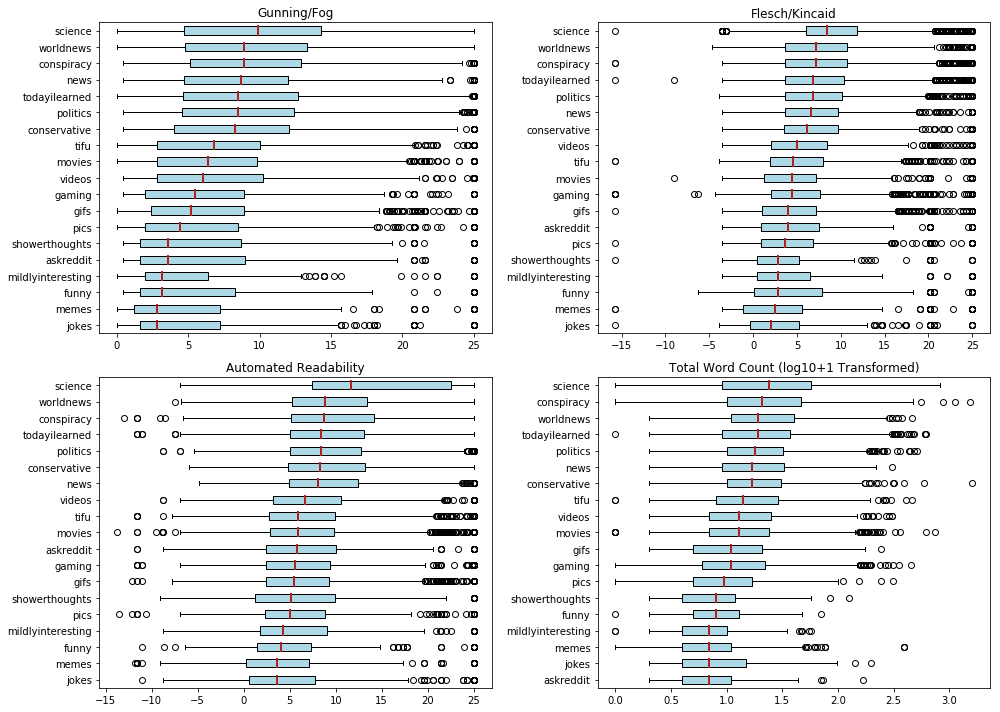

In [9]:
################################################################
# Graph the readability statistics

def my_stats_boxplot(stats, label, ax):
    subr = subreddit.copy()
    meds = [np.median(x) for x in stats]
    bp = ax.boxplot([x for _, x in sorted(zip(meds, stats))], 
                labels=[x for _, x in sorted(zip(meds, subr))], 
                   vert=False, patch_artist=True)
    plt.setp(bp['medians'], color='firebrick', linewidth=2)
    plt.setp(bp['boxes'], facecolor='lightblue')
    plt.setp(bp['fliers'], color='blue')
    ax.set_title(label)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
my_stats_boxplot(stats_gunfog, 'Gunning/Fog', ax[0,0])
my_stats_boxplot(stats_kincaid, 'Flesch/Kincaid', ax[0,1])
my_stats_boxplot(stats_autord, 'Automated Readability', ax[1,0])
my_stats_boxplot(stats_totlwd, 'Total Word Count (log10+1 Transformed)', ax[1,1])

plt.tight_layout()
plt.show()


Note that there are clearly differences in the distributions of text complexity statistics across these subreddits.

<h4>Association of score with text complexity</h4>

Next we analyze the scores.  To analyze scores we first need to normalize them to time, since a newer comment is going to have less time to collect Reddit “karma”.  However, a comment will have collected most of its “karma” after a sufficient amount of time (say 6 hours) has passed.  Here we assume that the origin (“current”) time is the time of the archive timestamp.

Note also that some subreddits hide a comment's score until a sufficient amount of time has passed.  The code needs to account for this by explicity assigning missing values to scores that are hidden.

In [10]:
################################################################
# Get comment scores, normalizing for time (up to 6 hours)

def score_per_hour(commDB,origin):
    tmst = [dt.datetime.fromtimestamp(s) for s in commDB['created']]
    delta = np.array([((origin - t).seconds)/3600 for t in tmst])
    scorePerHour = commDB['score']/np.minimum(delta+1/3600,6.0)
    scorePerHour[commDB['score_hidden']] = np.nan
    return(scorePerHour)

tstamps = [re.sub('-comments.pkl$','',re.sub('^reddit-[A-Za-z]*-', '', f)) for f in comment_files]
origins = [dt.datetime.strptime(re.sub('-[0-9]*$','',ts),'%Y-%m-%d-%H-%M-%S') for ts in tstamps]

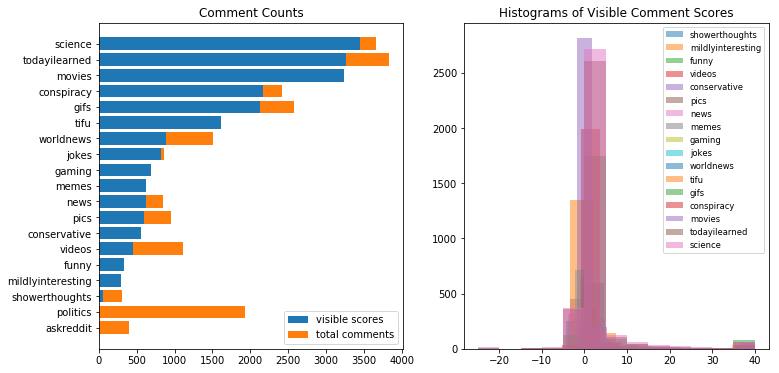

In [11]:
################################################################
# Graph comment counts, visible score counts, and 
#   show the distribution of scores

visible_scores = []
n_visible_scores = []
n_comments = []
for i in range(n_files):
    x = score_per_hour(comment_db[i], origins[i])
    n_comments.append(len(comment_db[i]))
    x = x[np.isnan(x)==False]
    visible_scores.append(x)
    n_visible_scores.append(len(x))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
lab = [x for _, x in sorted(zip(zip(n_visible_scores,n_comments), subreddit.copy()))]
n_v = [x for _, x in sorted(zip(zip(n_visible_scores,n_comments), n_visible_scores))]
n_c = [x for _, x in sorted(zip(zip(n_visible_scores,n_comments), n_comments))]

ax[0].barh(lab, n_c, label='visible scores')    
ax[0].barh(lab,[nc-nv for nc, nv in zip(n_c,n_v)],left=n_v,label='total comments')   
ax[0].set_title('Comment Counts')
ax[0].legend(loc='best')

for n, i in sorted(zip(n_visible_scores, range(n_files))):    
    if(n_visible_scores[i]>0):
        x = np.maximum(-25,np.minimum(visible_scores[i],40)) # Truncate to a visible range
        ax[1].hist(x, bins='sturges', label=subreddit[i], zorder=n)
lgnd = plt.legend(loc='best',fontsize='small')

# Make colors semi-transparent
for i in range(len(ax[1].patches)):
    fc = list(ax[1].patches[i]._facecolor)
    fc[3] = 0.5
    ax[1].patches[i]._facecolor = tuple(fc)
    
for i in range(len(lgnd.legendHandles)):
    fc = list(lgnd.legendHandles[i]._facecolor)
    fc[3] = 0.5
    lgnd.legendHandles[i]._facecolor = tuple(fc)
    
ax[1].set_title('Histograms of Visible Comment Scores')
plt.show()

We use the Spearman correlation coefficient to analyze the relationship between score text complexity.  The results can easily be visualized using a Volcano Plot, which plots each statistic by the negative log of its p-value; thus a higher value on the y-axis represents higher statistical significance.  Clearly for some subreddits there is a significant positive association between text complexity and score, although in every case the correlation is quite weak (less than 0.2 in absolute value).

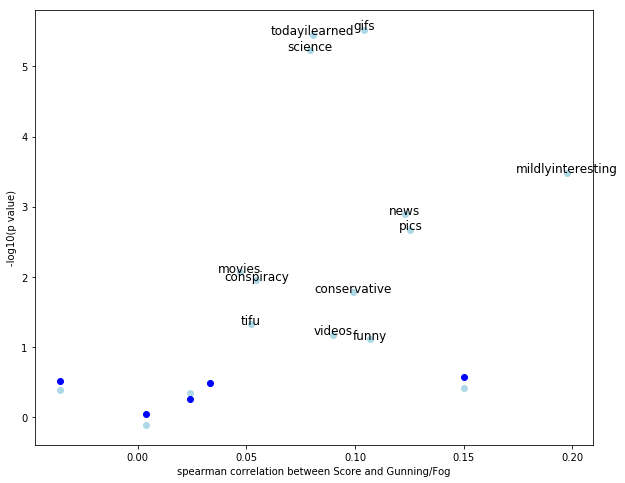

In [12]:
################################################################
# Use Spearman correlation to investigate the relationship
#  between readability (text complexity) and score

spearmans = []
for i in range(n_files):
    y = score_per_hour(comment_db[i], origins[i])
    x = np.array(stats_gunfog[i])
    flag = (np.isnan(y) == False)
    spearmans.append(stats.spearmanr(x[flag],y[flag]))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
x = np.array([r.correlation for r in spearmans])
y = np.array([-np.log10(r.pvalue) for r in spearmans])
flag = (np.isnan(y)==False)

# Note:  because of overlapping labels it is necessary to jitter y-values
np.random.seed(2)
def rand_jitter(arr):
    stdev = .025*(np.max(arr)-np.min(arr))
    return arr + np.random.randn(len(arr)) * stdev

x = x[flag]
y = y[flag]
yj = rand_jitter(y)

lab = np.array(subreddit)[flag]
insig = (y <= 1.0) # p=0.1 threshold
ax.plot(x, yj, 'o', color='lightblue')
ax.plot(x[insig], y[insig], 'bo')
for i in range(len(x)):
    if (not insig[i]):
        ax.annotate(lab[i], (x[i],yj[i]), fontsize=12, horizontalalignment='center')
plt.ylabel('-log10(p value)')
plt.xlabel('spearman correlation between Score and Gunning/Fog')
plt.show()

<h4>Construction of stem-to-word incidence matrices</h4>

Here we extract the nouns, verbs and adjectives (only) to construct a stem-to-word incidence matrix for each individual subreddit.

In [13]:
###############################################################
# Now we vectorize tags corresponding to specific parts-of-speech 
# (like sklearn.feature_extraction.text.CountVectorizer, but
#  using the part-of-speech tags to filter out most stop words
#  and also to get the word stems)
# This could take awhile to run because it uses sparse.lil_matrix
#  to incrementally build up to a csr sparse matrix.
comment_vecs = []
for i in range(n_files):
    comment_vecs.append(vectorize_tags(tagged_lists[i], types = ['N','V','J']))

<h4>Use of incidence matrix summary statistics to hierarchically cluster subreddits</h4>

First we get the union of stems across all subreddits.

In [14]:
###############################################################
# Get the union of stems across all subreddits and create an
#  indexing DataFrame
all_stems = set([])
for i in range(n_files):
    all_stems = all_stems.union(comment_vecs[i]['stems'])
n_stem = len(all_stems)
stem_tab = pd.DataFrame()
stem_tab['stem'] = list(all_stems)
stem_tab['index'] = list(range(n_stem))
stem_tab.set_index('stem', inplace=True)

Then we compute the subreddit-specific mean and standard deviation for each word.

In [15]:
###############################################################
# Get the mean and standard deviation for each word over each
#  subreddit

# Get mean and SD from sparse matrix
def get_mean_and_sd_vec(X):
    XX = X.multiply(X)
    n = X.shape[0]
    onevec = np.ones(n)
    mu = (onevec * X)/n
    m2 = (onevec * XX)/n
    sig = np.sqrt(m2-mu*mu)*np.sqrt(n/(n-1))
    return(mu, sig)

# Get container data frames
stem_mu = pd.DataFrame()
stem_sig = pd.DataFrame()

# Loop through subreddits to calculate stats and save
for i in range(n_files):
    mu, sig = get_mean_and_sd_vec(comment_vecs[i]['matrix'])
    mu2 = np.repeat(0.0,n_stem)
    sig2 = np.repeat(0.0,n_stem)
    ii = np.array(stem_tab.loc[comment_vecs[i]['stems']]['index'])
    mu2[ii] = mu
    #sig2[ii] = np.log(sig/np.sqrt(mu*(1-mu))) # dispersion
    sig2[ii] = sig
    stem_mu[subreddit[i]] = mu2
    stem_sig[subreddit[i]] = sig2
    

Finally, we use Ward's method of hierarchical clustering to cluster the subreddit stem incidence statistics.

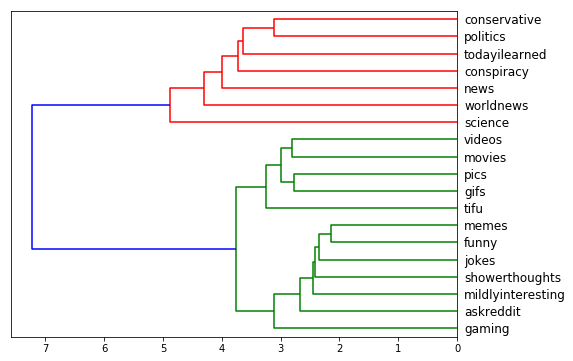

In [16]:
###############################################################
# Use Ward's clustering method to cluster based on the stats
#  and then visualize the resulting hierarchy
dmat = pdist(np.array(pd.concat([stem_mu,stem_sig])).transpose())
cluster_ward = ward(dmat)

fig, ax = plt.subplots(1,1,figsize=(8,6))
dendro_ward = dendrogram(cluster_ward,labels=subreddit,orientation='left',ax=ax)

<h4>Data summary statistics</h4>

Lastly, we tabulate summary statistics on the data used in the analysis.

In [17]:
###############################################################
# Get a "pretty" summary of the comments used in this analysis
# Note: counts should be taken into account in future runs, in
#  order to tune the collection to yield approximately 
#  the same number of comments

oldest = [np.min(cm['created']) for cm in comment_db]
oldestStr = [dt.datetime.fromtimestamp(o).strftime('%Y-%m-%d-%I-%M-%S') for o in oldest]
n_subs = [len(set(cm['subm_id'])) for cm in comment_db]

comment_summary = pd.DataFrame()
comment_summary['# submissions']=n_subs + [sum(n_subs)]
comment_summary['# comments']=n_comments + [sum(n_comments)]
comment_summary['timestamp'] = tstamps + ['']
comment_summary['oldest comment']=[o.replace(':','-').replace(' ','-').replace('.','-') for o in oldestStr] + ['']
comment_summary = comment_summary.set_index(np.array(subreddit + ['Total']))

comment_summary.sort_index()

,# submissions,# comments,timestamp,oldest comment
Total,1661,27766,,
askreddit,76,402,2019-07-18-16-58-43-332212,2019-07-19-12-48-11
conservative,74,556,2019-07-18-16-51-37-214559,2019-07-18-04-23-10
conspiracy,96,2420,2019-07-18-17-02-45-494250,2019-07-18-03-37-14
funny,75,335,2019-07-18-16-48-48-745655,2019-07-18-10-33-55
gaming,83,692,2019-07-18-16-47-52-652417,2019-07-18-09-35-57
gifs,43,2578,2019-07-18-17-07-31-645653,2019-07-18-01-16-21
jokes,169,865,2019-07-18-16-42-21-126349,2019-07-18-10-52-06
memes,180,623,2019-07-18-16-40-51-558039,2019-07-18-11-31-13
mildlyinteresting,87,291,2019-07-18-16-59-21-159904,2019-07-18-11-17-15


<h4>Appendix</h4>

<h5>Running the initial part of the analysis</h5>

If you wish to run this code, please follow these instructions.  First, you will need to register a [Reddit API account and install the python module *praw*](http://www.storybench.org/how-to-scrape-reddit-with-python/).  Then you will need to install [TreeTagger](https://www.cis.uni-muenchen.de/~schmid/tools/TreeTagger/). Next, [download](https://github.com/eahouseman/CommunityProjects-Misc) the utility files *reddit_utils.py*, *tree_tagger.py*, and *lexical_utils.py* and place them in a designated subdirectory, to be specified in the configuration file below.
In the same subdirectory from which you plan to run the notebook, create a text file called 
*ipynb_configs.txt*.  In that file store the following contents (with appropriate substitutions):

```
reddit_client_id=MY_REDDIT_CLIENT_ID
reddit_client_secret=MY_REDDIT_CLIENT_SECRET
reddit_user_agent=MY_REDDIT_CLIENT_TITLE
reddit_archive=PATH_TO_SUBDIR_FOR_STORING_ARCHIVES
python_utilities=PATH_TO_SUBDIR_CONTAINING_UTILITY_PY_FILES
```
Copy the file *getSubRedditComments.py* into the subdirectory from which you are running the notebook (or another one that contains an identical version of *ipynb_configs.txt*).  For each subreddit you plan to analyze run the following command (with appropriate substitutions):
```
python3 getSubRedditComments.py SUBREDDIT NUMSUBMISSIONS
```
Finally, run the code in this notebook.

<h5>Additional graphics to generate</h5>

Below we generate one of the figures used in the Introduction.

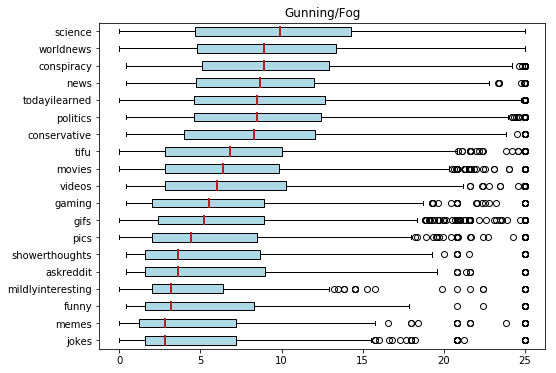

In [18]:
# Get a single box-plot of Gunning Fog statistics for use in the Introduction
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
my_stats_boxplot(stats_gunfog, 'Gunning/Fog', ax)
